In [41]:
from transformers import BertTokenizer
import pandas as pd
import torch
from torch import nn
import numpy as np
from transformers import BertTokenizer
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
# Загружаю уже обработанный текст твитов без стоп-слов
raw_data = pd.read_csv("ru-tweeter-sentiment.csv")
raw_data = raw_data.sample(20000)
raw_data.shape

(20000, 3)

In [62]:
raw_data = raw_data.drop("Unnamed: 0", axis=1)
raw_data = raw_data.dropna()
raw_data.shape

(19964, 2)

In [63]:
raw_data.columns

Index(['text_clear', 'label'], dtype='object')

In [64]:
raw_data.head()

,text_clear,label
94952,спасибо,1
126503,досмотрел игру престолов зарекался смотреть не...,0
150183,сгоняйте мной сити молл братцы,0
136222,вчерашний день вдали цивилизации немного расст...,0
63103,приду пирог кушать ок,1


In [65]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [66]:
labels = {
    'positive': 1,
    'negative': 0
}

In [67]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
#         self.labels = [labels[label] for label in df['category']]
        self.labels = df['label'].to_list()
#         print(type(df['context'][0]))
#         a = [tokenizer(text, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt") for text in df['context']]
#         self.texts = [tokenizer(text, padding = 'max_length', max_length = 512, truncation = True, return_tensors = "pt") for text in df['context']]
#         self.texts = df['context'].to_list()
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text_clear']]
#         text_tensors = []
        
#         for i in range(len(df)):
#             text_tensors.append(tokenizer(raw_data['context'][i],
#                    padding='max_length', max_length = 512, truncation=True,
#                    return_tensors="pt"))
        
#         self.texts = text_tensors
    
    
    
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        
        return batch_texts, batch_y

In [68]:
np.random.seed(112)

df_train, df_val, df_test = np.split(raw_data.sample(frac=1, random_state=42),
                                    [int(.8*len(raw_data)), int(.9*len(raw_data))])

print(len(df_train), len(df_val), len(df_test))

15971 1996 1997


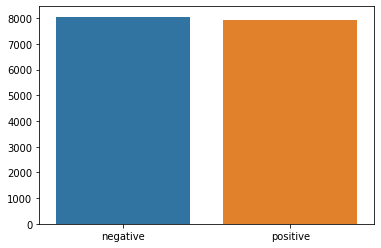

In [69]:
dd = pd.Series(df_train.label).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()   # количество позитивных и негативных практически равно

In [70]:
class BertClassifier(nn.Module):
    
    def __init__(self, dropout=0.5):
        
        super(BertClassifier, self).__init__()
        
        self.bert = BertModel
.from_pretrained("DeepPavlov/rubert-base-cased")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()
        
    def forward(self, input_id, mask):
        
        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)
        
        return final_layerBertModel


In [71]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()
        
    for epoch_num in range(epochs):
        total_accuracy_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)
            
            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            accuracy = (output.argmax(dim=1) == train_label).sum().item()
            total_accuracy_train += accuracy
            
            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
            
        total_accuracy_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            for val_input, val_label in val_dataloader:
                
                val_label = val_label.to(device)

                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                accuracy = (output.argmax(dim=1) == val_label).sum().item()
                total_accuracy_val += accuracy
                
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_accuracy_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_accuracy_val / len(val_data): .3f}')
            


In [72]:
EPOCHS = 3
model = BertClassifier()
LR = 1e-6

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [73]:
train(model, df_train, df_val, LR, EPOCHS)

  0%|▏                                      | 30/7986 [01:55<8:29:52,  3.85s/it]


KeyboardInterrupt: 

In [74]:
def get_text_class(text):
    tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
    tokenized_text = tokenizer(text, 
                               padding='max_length', 
                               max_length = 512, 
                               truncation=True,
                               return_tensors="pt")
    mask = tokenized_text['attention_mask']
    input_id = tokenized_text['input_ids'].squeeze(1)

    output = model(input_id, mask)
    print(output)
    return output.argmax(dim=1).item()

In [78]:
model = BertClassifier()
model.load_state_dict(torch.load("model_3_epochs", map_location=torch.device('cpu')))
model.eval()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [84]:
get_text_class("Как же они прикольно на английском базарят. Акшкли ай кен тп ботом то килл анд ретёрн")

tensor([[3.6960, 6.1004, 0.0000, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)


1

NameError: name 'WordCloud' is not defined